In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
data_measurement = pd.read_sql('SELECT * FROM measurement', engine)
data_measurement

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [6]:
data_station = pd.read_sql('SELECT * FROM station', engine)
data_station

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [7]:
# reflect an existing database into a new model

# reflect the tables


In [8]:
# View all of the classes that automap found
Base = automap_base()
# Use the base class to reflect the database tables
Base.prepare(autoload_with=engine)

#Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table - map the classes
measurement_reflected = Base.classes.measurement
station_reflected = Base.classes.station


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
inspector = inspect(engine)

In [12]:
# measurement table columns inspector
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'], c['primary_key'])

id INTEGER 1
station TEXT 0
date TEXT 0
prcp FLOAT 0
tobs FLOAT 0


In [13]:
# station table columns inspector
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'], c['primary_key'])

id INTEGER 1
station TEXT 0
name TEXT 0
latitude FLOAT 0
longitude FLOAT 0
elevation FLOAT 0


In [14]:
# Find the most recent date in the data set.
latest_date = (
    session
    .query(measurement_reflected.date)
    .order_by(measurement_reflected.date.desc())
    .first()
)

latest_date

('2017-08-23',)

In [15]:
# Calculate Previous Year
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

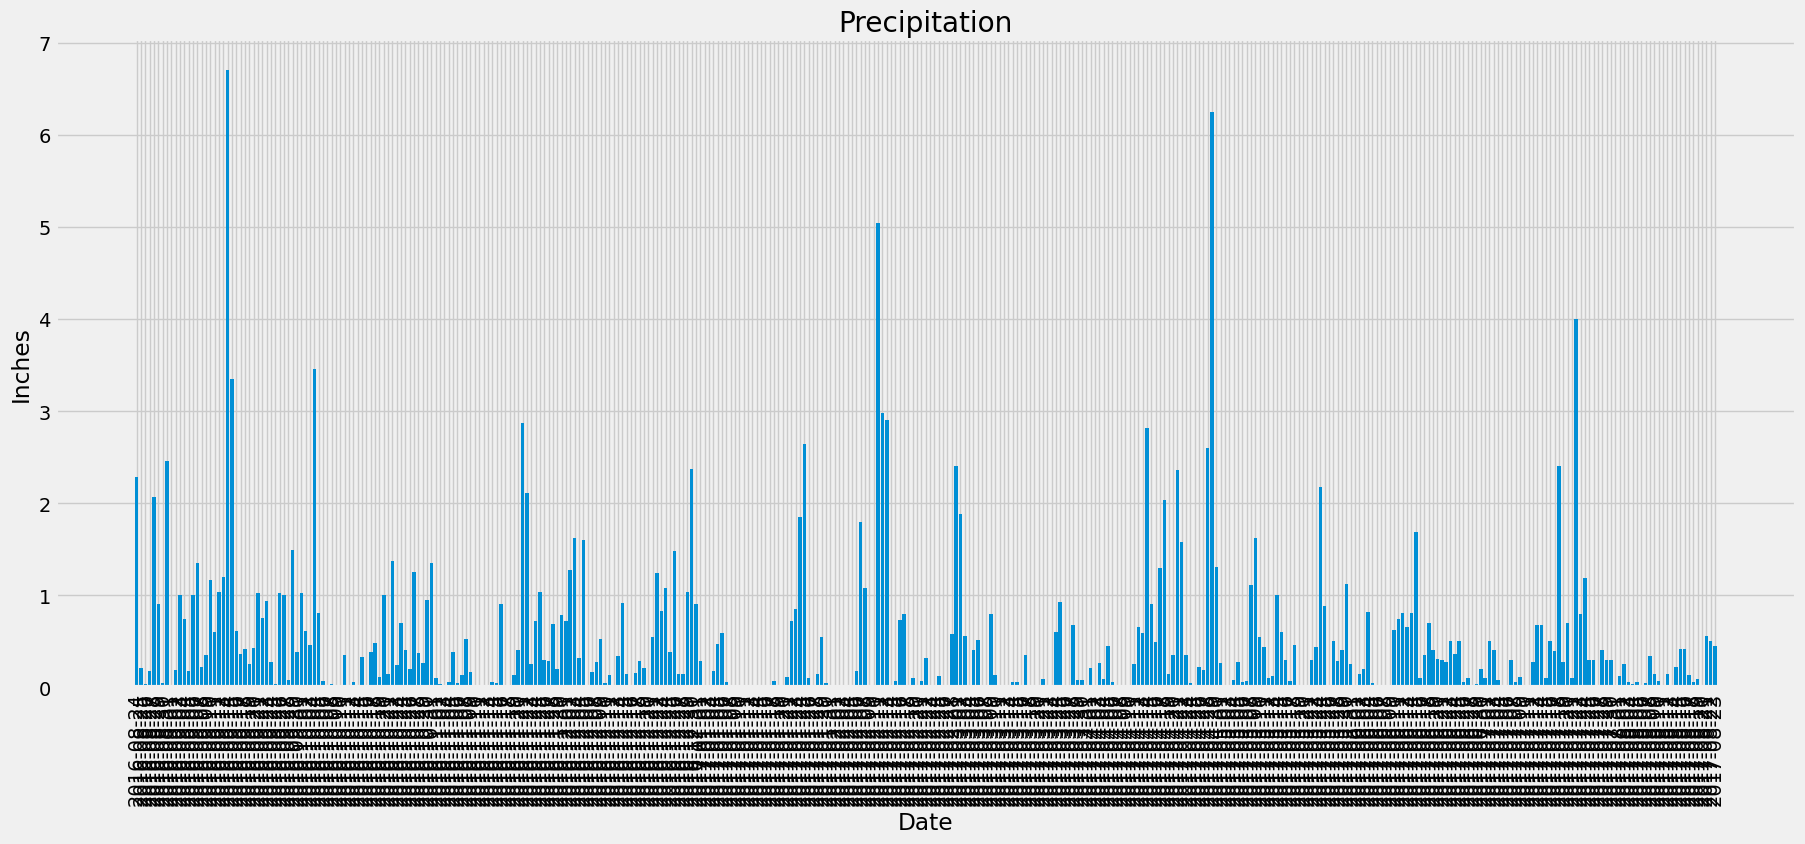

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
# Get last 12 months from previous date
last_12_months = (
    session
    .query(
        measurement_reflected.date,
        measurement_reflected.prcp
    )
    .filter(measurement_reflected.date > prev_year) # missing to change so its not hardcoded
    .order_by(measurement_reflected.date)
)

# transform to Data Frame
last_12_months = pd.DataFrame(last_12_months, columns = ['Date', 'Inches'])

# plot using mat plotlib
x_axis = last_12_months['Date']
y_axis = last_12_months['Inches']
plt.figure(figsize=[20,8])
plt.bar(x_axis, y_axis)
plt.title('Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation='vertical') # only missing to change ticks so they dont overlap.
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_12_months.describe()


,Inches
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number of stations in the dataset
number_stations = (
    session
    .query(func.distinct(measurement_reflected.station))
    .count()
    
)
number_stations

9

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

most_active_stations = (
    session
    .query(
        measurement_reflected.station, func.count(measurement_reflected.id) 
    )
    .group_by(measurement_reflected.station)
    .order_by(func.count(measurement_reflected.id).desc())
    .all()
)
    
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_temps = (
    session
    .query(
        func.min(measurement_reflected.tobs), func.max(measurement_reflected.tobs), func.avg(measurement_reflected.tobs)
    )
    .group_by(measurement_reflected.station)
    .order_by(func.count(measurement_reflected.id).desc())
    .first()
)
most_active_station_temps


(54.0, 85.0, 71.66378066378067)

<AxesSubplot:>

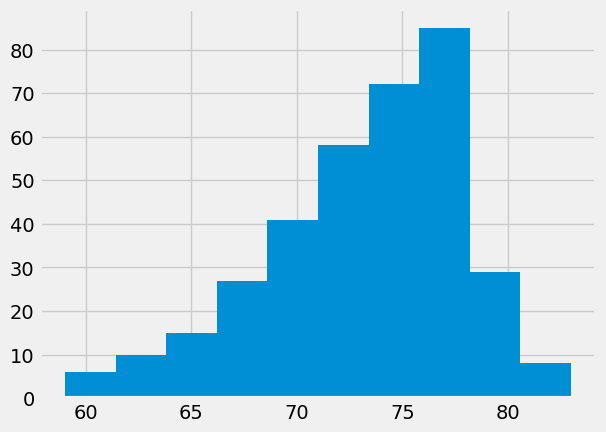

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
MostActive_last_12_months_temp = (
    session
    .query(
        measurement_reflected.date,
        measurement_reflected.tobs
    )
    .filter(
        (measurement_reflected.date > prev_year), 
        (measurement_reflected.station == 'USC00519281')
    )
    .all()
)

MostActive_last_12_months_temp

# transform to Data Frame
MostActive_last_12_months_temp = pd.DataFrame(MostActive_last_12_months_temp, columns = ['Date', 'Temperature'])
MostActive_last_12_months_temp

# Plot

MostActive_last_12_months_temp['Temperature'].hist()


# Close Session

In [22]:
# Close Session
session.close()